# Bayes by Backprop from scratch (NN, classification)

We have already learned how to implement deep neural networks and how to use them for classification and regression tasks. In order to fight overfitting, we further introduced a concept called _dropout_, which randomly turns off a certain percentage of the weights during training.

Recall the classic architecture of a MLP (shown below, without bias terms). So far, when training a neural network, our goal was to find an optimal point estimate for the weights.

![](https://github.com/zackchase/mxnet-the-straight-dope/blob/master/img/bbb_nn_classic.png?raw=true)

While networks trained using this approach usually perform well in regions with lots of data, they fail to express uncertainity in regions with little or no data, leading to overconfident decisions. This drawback motivates the application of Bayesian learning to neural networks, introducing probability distributions over the weights. These distributions can be of various nature in theory. To make our lifes easier and to have an intuitive understanding of the distribution at each weight, we will use a Gaussian distribution.

![](https://github.com/zackchase/mxnet-the-straight-dope/blob/master/img/bbb_nn_bayes.png?raw=true)

Unfortunately though, exact Bayesian inference on the parameters of a neural network is intractable. One promising way of addressing this problem is presented by the "Bayes by Backprop" algorithm (introduced by the "[Weight Uncertainity in Neural Networks](https://arxiv.org/abs/1505.05424)" paper) which derives a variational approximation to the true posterior. This algorithm does not only make networks more "honest" with respect to their overall uncertainity, but also automatically leads to regularization, thereby eliminating the need of using dropout in this model.

While we will try to explain the most important concepts of this algorithm in this notebook, we also encourage the reader to consult the paper for deeper insights.

Let's start implementing this idea and evaluate its performance on the MNIST classification problem. We start off with the usual set of imports.

In [61]:
from __future__ import print_function
import collections
import mxnet as mx
import numpy as np
from mxnet import nd, autograd
from matplotlib import pyplot as plt
import time

For easy tuning and experimentation, we define a dictionary holding the hyper-parameters of our model.

In [36]:
config = {
    "num_hidden_layers": 2,
    "num_hidden_units": 400, 
    "batch_size": 128,
    "epochs": 10,
    "learning_rate": 0.001,
    "num_samples": 1,
    "pi": 0.25,
    "sigma_p": 1.0,
    "sigma_p1": 0.75,
    "sigma_p2": 0.1,
}

Also, we specify the device context for MXNet.

In [37]:
ctx = mx.cpu()

## Load MNIST data

We will again train and evaluate the algorithm on the MNIST data set and therefore load the data set as follows:

In [38]:
def transform(data, label):
    return data.astype(np.float32)/126.0, label.astype(np.float32)

mnist = mx.test_utils.get_mnist()
num_inputs = 784
num_outputs = 10
batch_size = config['batch_size']

train_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=True, transform=transform),
                                      batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                                     batch_size, shuffle=False)

num_train = sum([batch_size for i in train_data])
print(num_train)
num_batches = num_train / batch_size

60032


In order to reproduce and compare the results from the paper, we preprocess the pixels by dividing by 126.

## Model definition

### Activation function

As with lots of past examples, we will again use the ReLU as our activation function for the hidden units of our neural network.

In [39]:
def relu(X):
    return nd.maximum(X, nd.zeros_like(X))

### Neural net modeling

As our model we are using a straightforward MLP and we are wiring up our network just as we are used to.

In [40]:
num_layers = config['num_hidden_layers']

# define function for evaluating MLP
def net(X, layer_params):
    layer_input = X
    for i in range(len(layer_params) // 2 - 2):
        h_linear = nd.dot(layer_input, layer_params[2*i]) + layer_params[2*i + 1]
        layer_input = relu(h_linear)
    # last layer without ReLU
    output = nd.dot(layer_input, layer_params[-2]) + layer_params[-1]
    return output

# define network weight shapes
layer_param_shapes = []
num_hidden = config['num_hidden_units']
for i in range(num_layers + 1):
    if i == 0: # input layer
        W_shape = (num_inputs, num_hidden)
        b_shape = (num_hidden,)  
    elif i == num_layers: # last layer
        W_shape = (num_hidden, num_outputs)
        b_shape = (num_outputs,)
    else: # hidden layers
        W_shape = (num_hidden, num_hidden)
        b_shape = (num_hidden,)
    layer_param_shapes.extend([W_shape, b_shape])

## Build objective/loss

As we briefly mentioned at the beginning of the notebook, we will use variational inference in order to make the prediction of the posterior tractable. While we can not model the posterior $P(\mathbf{w}\ |\ \mathcal{D})$ directly, we try to find the parameters $\mathbf{\theta}$ of a distribution on the weights $q(\mathbf{w}\ |\ \mathbf{\theta})$ (commly referred to as the _variational posterior_) that minimizes the KL divergence with the true posterior. Formally this can be expressed as:

\begin{equation*}
\begin{split}
\theta^{*} & = \arg\min_{\theta} \text{KL}[q(\mathbf{w}\ |\ \mathbf{\theta})\ ||\ P(\mathbf{w}\ |\ \mathcal{D}]\\
& = \arg\min_{\theta} \int q(\mathbf{w}\ |\ \mathbf{\theta}) \log \frac{q(\mathbf{w}\ |\ \mathbf{\theta})}{P(\mathbf{w}) P(\mathcal{D}\ |\ \mathbf{w})} d\mathbf{w} \\
& = \arg\min_{\theta} \text{KL}[q(\mathbf{w}\ |\ \mathbf{\theta})\ ||\ P(\mathbf{w})] - \mathbb{E}_{q(\mathbf{w}\ |\ \mathbf{\theta})}[\log P(\mathcal{D}\ |\ \mathbf{w})]
\end{split}
\end{equation*}

The resulting loss function, commonly referred to as either _variational free energy_ or _expected lower bound_ (_ELBO_), has to be minimized and is then given as follows:

\begin{equation*}
\mathcal{F}(\mathcal{D}, \mathbf{\theta}) = \text{KL}[q(\mathbf{w}\ |\ \mathbf{\theta})\ ||\ P(\mathbf{w})] - \mathbb{E}_{q(\mathbf{w}\ |\ \mathbf{\theta})}[\log P(\mathcal{D}\ |\ \mathbf{w})]
\end{equation*}

As one can easily see, the cost function tries to balance the complexity of the data $P(\mathcal{D}\ |\ \mathbf{w})$ and the simplicity of the prior $P(\mathbf{w})$.

We can approximate this exact cost through a Monte Carlo sampling procedure as follows

\begin{equation*}
\mathcal{F}(\mathcal{D}, \mathbf{\theta}) \approx \sum_{i = 1}^{n} \log q(\mathbf{w}^{(i)}\ |\ \mathbf{\theta}) - \log P(\mathbf{w}^{(i)}) - \log P(\mathcal{D}\ |\ \mathbf{w}^{(i)})
\end{equation*}

where $\mathbf{w}^{(i)}$ corresponds to the $i$-th Monte Carlo sample from the variational posterior. While writing this notebook, we noticed that even taking just one sample leads to good results and we will therefore stick to just sampling once throughout the notebook.

Since we will be working with mini-batches, the exact loss form on mini-batch $i$ we will be using looks as follows:

\begin{equation*}
\begin{split}
\mathcal{F}(\mathcal{D}_i, \mathbf{\theta}) & = \frac{1}{M} \text{KL}[\log q(\mathbf{w}\ |\ \mathbf{\theta})\ ||\ \log P(\mathbf{w})] - \mathbb{E}_{q(\mathbf{w}\ |\ \mathbf{\theta})}[\log P(\mathcal{D}_i\ |\ \mathbf{w})]\\
& \approx \frac{1}{M} (\log q(\mathbf{w}^{(1)}\ |\ \mathbf{\theta}) - \log P(\mathbf{w}^{(1)})) - \log P(\mathcal{D}_i\ |\ \mathbf{w}^{(1)})
\end{split}
\end{equation*}

where $M$ corresponds to the number of batches,
and $\mathcal{F}(\mathcal{D}, \mathbf{\theta}) = \sum_{i = 1}^{M} \mathcal{F}(\mathcal{D}_i, \mathbf{\theta})$

Let's now look at each of these single terms individually.

### Likelihood

As with lots of past examples, we will again use the softmax to define our likelihood $P(\mathcal{D}_i\ |\ \mathbf{w})$. Revisit the [MLP from scratch notebook](https://github.com/zackchase/mxnet-the-straight-dope/blob/master/chapter03_deep-neural-networks/mlp-scratch.ipynb) for a detailed motivation of this function.

In [41]:
def log_softmax_likelihood(yhat_linear, y):
    return nd.nansum(y * nd.log_softmax(yhat_linear), axis=0, exclude=True)

### Prior

Since we are introducing a Bayesian treatment for the network, we need to define a Prior over the weights.

#### Gaussian prior

A popular and simple prior is the Gaussian distribution. The prior over the entire weight vector simply corresponds to the prodcut of the individual Gaussians:

\begin{equation*}
P(\mathbf{w}) = \prod_i \mathcal{N}(\mathbf{w}_i\ |\ 0,\sigma_p^2)
\end{equation*}

We can define the Gaussian distribution and our Gaussian prior as seen below. Note that we are ultimately intersted in the log-prior $\log P(\mathbf{w})$ and therefore compute the sum of the log-Gaussians.

\begin{equation*}
\log P(\mathbf{w}) = \sum_i \log \mathcal{N}(\mathbf{w}_i\ |\ 0,\sigma_p^2)
\end{equation*}

In [42]:
LOG2PI = np.log(2.0 * np.pi)

def log_gaussian(x, mu, sigma):
    return -0.5 * LOG2PI - nd.log(sigma) - (x - mu) ** 2 / (2 * sigma ** 2)

def gaussian_prior(x):
    sigma_p = nd.array([config['sigma_p']], ctx=ctx)
    
    return nd.sum(log_gaussian(x, 0., sigma_p))
d = nd.array([1,2])
a = gaussian_prior(d)
print(a)


[-4.3378773]
<NDArray 1 @cpu(0)>


#### Scale mixture prior

Instead of a single Gaussian, the paper also suggests the usage of a scale mixture prior for $P(\mathbf{w})$ as an alternative:

\begin{equation*}
P(\mathbf{w}) = \prod_i \bigg ( \pi \mathcal{N}(\mathbf{w}_i\ |\ 0,\sigma_1^2) + (1 - \pi) \mathcal{N}(\mathbf{w}_i\ |\ 0,\sigma_2^2)\bigg )
\end{equation*}

where $\pi \in [0, 1]$, $\sigma_1 > \sigma_2$ and $\sigma_2 \ll 1$. Again we are intersted in the log-prior $\log P(\mathbf{w})$, which can be expressed as follows:

\begin{equation*}
\log P(\mathbf{w}) = \sum_i \log \bigg ( \pi \mathcal{N}(\mathbf{w}_i\ |\ 0,\sigma_1^2) + (1 - \pi) \mathcal{N}(\mathbf{w}_i\ |\ 0,\sigma_2^2)\bigg )
\end{equation*}

In [43]:
def gaussian(x, mu, sigma):
    scaling = 1.0 / nd.sqrt(2.0 * np.pi * (sigma ** 2))
    bell = nd.exp(- (x - mu) ** 2 / (2.0 * sigma ** 2))
    
    return scaling * bell

def scale_mixture_prior(x):
    sigma_p1 = nd.array([config['sigma_p1']], ctx=ctx)
    sigma_p2 = nd.array([config['sigma_p2']], ctx=ctx)
    pi = config['pi']
    
    first_gaussian = pi * gaussian(x, 0., sigma_p1)
    second_gaussian = (1 - pi) * gaussian(x, 0., sigma_p2)
    
    return nd.log(first_gaussian + second_gaussian)

### Variational Posterior

The last missing piece in the equation is the variational posterior. Again, we choose a Gaussian disribution for this purpose. The variational posterior on the weights is centered on the mean vector $\mathbf{\mu}$ and has variance $\mathbf{\sigma}^2$:

\begin{equation*}
q(\mathbf{w}\ |\ \theta) = \prod_i \mathcal{N}(\mathbf{w}_i\ |\ \mathbf{\mu},\mathbf{\sigma}^2)
\end{equation*}

The log-posterior $\log q(\mathbf{w}\ |\ \theta)$ is given by:

\begin{equation*}
\log q(\mathbf{w}\ |\ \theta) = \sum_i \log \mathcal{N}(\mathbf{w}_i\ |\ \mathbf{\mu},\mathbf{\sigma}^2)
\end{equation*}

### Combined Loss

After introducing the data likelihood, the prior, and the variational posterior, we are now able to build our combined loss function: $\mathcal{F}(\mathcal{D}_i, \mathbf{\theta}) = \frac{1}{M} (\log q(\mathbf{w}\ |\ \mathbf{\theta}) - \log P(\mathbf{w})) - \log P(\mathcal{D}_i\ |\ \mathbf{w})$

In [114]:
def combined_loss(output, label_one_hot, params, mus, sigmas, log_prior, log_likelihood,time_lo,time_prior,time_like,time_post):

    # Calculate data likelihood
    start_like = time.clock()
    log_likelihood_sum = nd.sum(log_likelihood(output, label_one_hot))
    time_like += time.clock()-start_like
    # Calculate variational posterior
    start_post = time.clock()
    log_var_posterior_sum = sum([nd.sum(log_gaussian(params[i], mus[i], sigmas[i])) for i in range(len(params))])
    time_post += time.clock()-start_post
    # Calculate prior
#     s = time.clock()
#     sig = nd.array([1],ctx=ctx)
#     es += time.clock() - s
    start_prior = time.clock()
#     log_prior_sum = sum([nd.sum(log_prior(param)) for param in params])
    log_prior_sum= sum([nd.sum(log_gaussian(params[i],0,sigmas[i])) for i in range(len(params))])
    time_prior += time.clock()-start_prior
    start_lo = time.clock()
    los = 1.0 / num_batches * (log_var_posterior_sum - log_prior_sum) - log_likelihood_sum
    time_lo += time.clock() - start_lo
    # Calculate total loss
    return los, time_lo,time_prior,time_like,time_post

## Optimizer

We use vanilla stochastic gradient descent to optimize the variational parameters. Note that this implements the updates described in the paper, as the gradient contribution due to the reparametrization trick is automatically included by taking the gradients of the combined loss function with respect to the variational parameters.

In [45]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

## Evaluation metric

In order to being able to assess our model performance we define a helper function which evaluates our accuracy on an ongoing basis.

In [46]:
def evaluate_accuracy(data_iterator, net, layer_params):
    numerator = 0.
    denominator = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1, 784))
        label = label.as_in_context(ctx)
        output = net(data, layer_params)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
    return (numerator / denominator).asscalar()

## Parameter initialization

We are using a Gaussian distribution for each individual weight as our variational posterior, which means that we need to store two parameters, mean and variance, for each weight. For the variance we need to ensure that it is non-negative, which we will do by using the softplus function to express $\mathbf{\sigma}$ in terms of an unconstrained parameter $\mathbf{\rho}$. While gradient descent will be performed on $\theta = (\mathbf{\mu}, \mathbf{\rho})$, the distribution for each individual weight is represented as $w_i \sim \mathcal{N}(w_i\ |\ \mu_i,\sigma_i)$ with $\sigma_i = \text{softplus}(\mathbf{\rho}_i)$.

We initialize $\mathbf{\mu}$ with a Gaussian around $0$ (just as we would initialize standard weights of a neural network). It is important to initialize $\mathbf{\rho}$ (and hence $\sigma$) to a small value, otherwise learning might not work properly.

In [47]:
weight_scale = .1
rho_offset = -3

# initialize variational parameters; mean and variance for each weight
mus = []
rhos = []
    
for shape in layer_param_shapes:
    mu = nd.random_normal(shape=shape, ctx=ctx, scale=weight_scale)
    rho = rho_offset + nd.zeros(shape=shape, ctx=ctx)
    mus.append(mu)
    rhos.append(rho)

variational_params = mus + rhos


Since these are the parameters we wish to do gradient descent on, we need to allocate space for storing the gradients.

In [48]:
for param in variational_params:
    param.attach_grad()

## Main training loop



The main training loop is pretty similar to the one we used in the MLP example. The only adaptation we need to make is to add the weight sampling which is performed during each optimization step. Generating a set of weights, which will subsequently be used in the neural network and the loss function, is a 3-step process:

1) Sample $\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0},\mathbf{I}^{d})$

In [49]:
def sample_epsilons(param_shapes):
    epsilons = [nd.random_normal(shape=shape, loc=0., scale=1.0, ctx=ctx) for shape in param_shapes]
    return epsilons

2) Transform $\mathbf{\rho}$ to a postive vector via the softplus function: $\mathbf{\sigma} = \text{softplus}(\mathbf{\rho}) = \log(1 + \exp(\mathbf{\rho}))$

In [50]:
def softplus(x):
    return nd.log(1. + nd.exp(x))

def transform_rhos(rhos):
    return [softplus(rho) for rho in rhos]

3) Compute $\mathbf{w}$: $\mathbf{w} = \mathbf{\mu} + \mathbf{\sigma} \circ \mathbf{\epsilon}$, where the $\circ$ operator represents the element-wise multiplication. This is the "reparametrization trick" for separating the randomness from the parameters of $q$.

In [51]:
def transform_gaussian_samples(mus, sigmas, epsilons):
    samples = []
    for j in range(len(mus)):
        samples.append(mus[j] + sigmas[j] * epsilons[j])
    return samples

### Complete loop

The complete training loop is given below.

In [118]:
%%time
epochs = config['epochs']
learning_rate = config['learning_rate']
smoothing_constant = .01
train_acc = []
test_acc = []
tp = 0
tl = 0
tpo = 0
tlo = 0
es = 0
for e in range(1):
    elst_sample = 0
    elst_forw = 0
    elst_back = 0
    elst_cal = 0
    elst_loss = 0
    elst_load = 0
    elst_trans = 0
    total = 0
    start_total = time.clock()
    for i, (data, label) in enumerate(train_data):
        start_load = time.clock()
        data = data.as_in_context(ctx).reshape((-1, 784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        elst_load += time.clock() - start_load
        with autograd.record():
            # sample epsilons from standard normal
            start_time = time.clock()
            epsilons = sample_epsilons(layer_param_shapes)
            # print("---sampling took %s seconds ---" % (time.time() - start_time))
            elst_sample += time.clock() - start_time
            
            # compute softplus for variance
            start_trans = time.clock()
            sigmas = transform_rhos(rhos)
            
            # obtain a sample from q(w|theta) by transforming the epsilons
            layer_params = transform_gaussian_samples(mus, sigmas, epsilons)
            elst_trans = time.clock() -start_trans
            # forward-propagate the batch
            start_forward = time.clock()
            output = net(data, layer_params)
            # print("---forward took %s seconds----" %(time.time() - start_forward))
            elst_forw += time.clock() - start_forward
            # calculate the loss
            start_cal = time.clock()
            loss,tlo,tp,tl,tpo = combined_loss(output, label_one_hot, layer_params, mus, sigmas, gaussian_prior, log_softmax_likelihood,tlo,tp,tl,tpo)
            elst_cal += time.clock() - start_cal
        # backpropagate for gradient calculation
        start_back = time.clock()
        loss.backward()
        
        # apply stochastic gradient descent to variational parameters
        SGD(variational_params, learning_rate)
        # print("---backward took %s seconds----" %(time.time() - start_back))
        elst_back += time.clock() - start_back
    total += time.clock() - start_total
        # calculate moving loss for monitoring convergence
#       start_loss = time.clock()
        #print(start_loss)
#         curr_loss = nd.mean(loss).asscalar()
#         moving_loss = (curr_loss if ((i == 0) and (e == 0)) 
#                        else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)
#         elst_loss += time.clock() - start_loss
        #print(elst_loss)
        #print("%d minibatch finished" %i)
        
        
#     test_accuracy = evaluate_accuracy(test_data, net, mus)
#     train_accuracy = evaluate_accuracy(train_data, net, mus)
#     train_acc.append(np.asscalar(train_accuracy))
#     test_acc.append(np.asscalar(test_accuracy))
#     print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" %
#           (e, moving_loss, train_accuracy, test_accuracy))
print("sample: %5f" % elst_sample)
print("forw: %5f" % elst_forw)
print("back: %5f" % elst_back)
print("calculate loss: %5f" % elst_cal)
# print("load: %5f" % elst_load)
# print("trans: %5f" % elst_trans)
print("prior: %5f" % tp)
print("like: %5f" % tl)
print("post: %5f" % tpo)
#print("lo: %5f" % tlo)
# print("es: %5f" % es)
print("total: %5f" % total)

#print("loss: %5f" % elst_loss)
# plt.plot(train_acc)
# plt.plot(test_acc)
# plt.show()

sample: 0.149061
forw: 0.096722
back: 2.714273
calculate loss: 1.992545
prior: 0.938303
like: 0.077692
post: 0.921138
total: 14.175836
Wall time: 14.2 s


For demonstration purposes, we can now take a look at one particular weight by plotting its distribution.

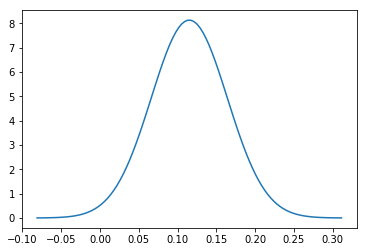

In [19]:
def show_weight_dist(mean, variance):
    sigma = nd.sqrt(variance)
    x = np.linspace(mean.asscalar() - 4*sigma.asscalar(), mean.asscalar() + 4*sigma.asscalar(), 100)
    plt.plot(x, gaussian(nd.array(x, ctx=ctx), mean, sigma).asnumpy())
    plt.show()
    
mu = mus[0][0][0]
var = softplus(rhos[0][0][0]) ** 2

show_weight_dist(mu, var)

Great! We have obtained a fully functional Bayesian neural network. However, the number of weights now is twice as high as for traditional neural networks. As we will see in the final section of this notebook, we are able to drastically reduce the number of weights our network uses for prediction with _weight pruning_.

## Weight pruning

To measure the degree of redundancy present in the trained network and to reduce the model's parameter count, we now want to examine the effect of setting some of the weights to $0$ and evaluate the test accuracy afterwards. We can achieve this by ordering the weights according to their signal-to-noise-ratio, $\frac{|\mu_i|}{\sigma_i}$, and setting a certain percentage of the weights with the lowest ratios to $0$.

We can calculate the signal-to-noise-ratio as follows:

In [20]:
def signal_to_noise_ratio(mus, sigmas):
    sign_to_noise = []
    for j in range(len(mus)):
        sign_to_noise.extend([nd.abs(mus[j]) / sigmas[j]])
    return sign_to_noise

We further introduce a few helper methods which turn our list of weights into a single vector containing all weights. This will make our subsequent actions easier.

In [21]:
def vectorize_matrices_in_vector(vec):
    for i in range(0, (num_layers + 1) * 2, 2):
        if i == 0:
            vec[i] = nd.reshape(vec[i], num_inputs * num_hidden)
        elif i == num_layers * 2:
            vec[i] = nd.reshape(vec[i], num_hidden * num_outputs)
        else:
            vec[i] = nd.reshape(vec[i], num_hidden * num_hidden)
            
    return vec

def concact_vectors_in_vector(vec):
    concat_vec = vec[0]
    for i in range(1, len(vec)):
        concat_vec = nd.concat(concat_vec, vec[i], dim=0)
    
    return concat_vec

def transform_vector_structure(vec):
    vec = vectorize_matrices_in_vector(vec)
    vec = concact_vectors_in_vector(vec)
    
    return vec

In addition, we also have a helper method which transforms the pruned weight vector back to the original layered structure.

In [22]:
from functools import reduce
import operator

def prod(iterable):
    return reduce(operator.mul, iterable, 1)

def restore_weight_structure(vec):
    pruned_weights = []
    
    index = 0
    
    for shape in layer_param_shapes:
        incr = prod(shape)
        pruned_weights.extend([nd.reshape(vec[index : index + incr], shape)])
        index += incr
    
    return pruned_weights

The actual pruning of the vector happens in the following function. Note that this function accepts an ordered list of percentages to evaluate the performance at different pruning rates. In this setting, pruning at each iteration means extracting the index of the lowest signal-to-noise-ratio weight and setting the weight at this index to $0$.

In [23]:
def prune_weights(sign_to_noise_vec, prediction_vector, percentages):
    pruning_indices = nd.argsort(sign_to_noise_vec, axis=0)
    
    for percentage in percentages:
        prediction_vector = mus_copy_vec.copy()
        pruning_indices_percent = pruning_indices[0:int(len(pruning_indices)*percentage)]
        for pr_ind in pruning_indices_percent:
            prediction_vector[int(pr_ind.asscalar())] = 0
        pruned_weights = restore_weight_structure(prediction_vector)
        test_accuracy = evaluate_accuracy(test_data, net, pruned_weights)
        print("%s --> %s" % (percentage, test_accuracy))

Putting the above functions together:

In [24]:
sign_to_noise = signal_to_noise_ratio(mus, sigmas)
sign_to_noise_vec = transform_vector_structure(sign_to_noise)

mus_copy = mus.copy()
mus_copy_vec = transform_vector_structure(mus_copy)

prune_weights(sign_to_noise_vec, mus_copy_vec, [0.1, 0.25, 0.5, 0.75, 0.95, 0.99, 1.0])

0.1 --> 0.9777
0.25 --> 0.9779
0.5 --> 0.9756
0.75 --> 0.9602
0.95 --> 0.7259
0.99 --> 0.3753
1.0 --> 0.098


Depending on the number of units used in the original network and the number of training epochs, the highest achievable pruning percentages (without significantly reducing the predictive performance) can vary. The paper, for example, reports almost no change in the test accuracy when pruning 95% of the weights in a 2x1200 unit Bayesian neural network, which creates a significantly sparser network, leading to faster predictions and reduced memory requirements.

## Conclusion

We have taken a look at an efficient Bayesian treatment for neural networks using variational inference via the "Bayes by Backprop" algorithm (introduced by the "[Weight Uncertainity in Neural Networks](https://arxiv.org/abs/1505.05424)" paper). We have implemented a stochastic version of the variational lower bound and optimized it in order to find an approximation to the posterior distribution over the weights of a MLP network on the MNIST data set. As a result, we achieve regularization on the network's parameters and can quantify our uncertainty about the weights accurately. Finally, we saw that it is possible to significantly reduce the number of weights in the neural network after training while still keeping a high accuracy on the test set.

We also note that, given this model implementation, we were able to reproduce the paper's results on the MNIST data set, achieving a comparable test accuracy for all documented instances of the MNIST classification problem.

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)